In [1]:
import pandas as pd

## Load h5 data

In [2]:
import h5py

with h5py.File('2024-57__ETH-USD_trades.h5', 'r') as f:
    # Print the structure first to see what's available
    def print_structure(name, obj):
        print(f"Name: {name}")
        if isinstance(obj, h5py.Dataset):
            print(f"    Shape: {obj.shape}")
            print(f"    Type: {obj.dtype}")
    
    print("File structure:")
    f.visititems(print_structure)
    
    # Read the BTC-USD dataset
    trades_eth_usdt = f['ETH-USDTrades/ETH-USDTrades'][:]

File structure:
Name: ETH-USDTrades
Name: ETH-USDTrades/ETH-USDTrades
    Shape: (2230,)
    Type: [('Price', '<f8'), ('PriceMillionths', '<i8'), ('Side', 'i1'), ('Size', '<f8'), ('SizeBillionths', '<i8'), ('received_utc', '<f8'), ('received_utc_nanoseconds', '<u8'), ('timestamp_utc', '<f8'), ('timestamp_utc_nanoseconds', '<u8')]


In [3]:
import h5py

with h5py.File('2024-57__ETH-USD_orders.h5', 'r') as f:
    # Print the structure first to see what's available
    def print_structure(name, obj):
        print(f"Name: {name}")
        if isinstance(obj, h5py.Dataset):
            print(f"    Shape: {obj.shape}")
            print(f"    Type: {obj.dtype}")
    
    print("File structure:")
    f.visititems(print_structure)
    
    # Read the BTC-USD dataset
    orders_eth_usdt = f['Level2/ETH-USD'][:]

File structure:
Name: Level2
Name: Level2/ETH-USD
    Shape: (96475,)
    Type: [('Ask1PriceMillionths', '<i8'), ('Ask1SizeBillionths', '<i8'), ('Ask2PriceMillionths', '<i8'), ('Ask2SizeBillionths', '<i8'), ('Ask3PriceMillionths', '<i8'), ('Ask3SizeBillionths', '<i8'), ('Bid1PriceMillionths', '<i8'), ('Bid1SizeBillionths', '<i8'), ('Bid2PriceMillionths', '<i8'), ('Bid2SizeBillionths', '<i8'), ('Bid3PriceMillionths', '<i8'), ('Bid3SizeBillionths', '<i8'), ('received_utc_microseconds', '<u8'), ('received_utc_nanoseconds', '<u8'), ('timestamp_utc_nanoseconds', '<u8')]


In [4]:
import h5py

with h5py.File('2024-57__ETH-BTC_trades.h5', 'r') as f:
    # Print the structure first to see what's available
    def print_structure(name, obj):
        print(f"Name: {name}")
        if isinstance(obj, h5py.Dataset):
            print(f"    Shape: {obj.shape}")
            print(f"    Type: {obj.dtype}")
    
    print("File structure:")
    f.visititems(print_structure)
    
    # Read the BTC-USD dataset
    trades_eth_btc = f['ETH-BTCTrades/ETH-BTCTrades'][:]

File structure:
Name: ETH-BTCTrades
Name: ETH-BTCTrades/ETH-BTCTrades
    Shape: (1437,)
    Type: [('Price', '<f8'), ('PriceMillionths', '<i8'), ('Side', 'i1'), ('Size', '<f8'), ('SizeBillionths', '<i8'), ('received_utc', '<f8'), ('received_utc_nanoseconds', '<u8'), ('timestamp_utc', '<f8'), ('timestamp_utc_nanoseconds', '<u8')]


In [5]:
import h5py

with h5py.File('2024-57__ETH-BTC_orders.h5', 'r') as f:
    # Print the structure first to see what's available
    def print_structure(name, obj):
        print(f"Name: {name}")
        if isinstance(obj, h5py.Dataset):
            print(f"    Shape: {obj.shape}")
            print(f"    Type: {obj.dtype}")
    
    print("File structure:")
    f.visititems(print_structure)
    
    # Read the BTC-USD dataset
    orders_eth_btc = f['Level2/ETH-BTC'][:]

File structure:
Name: Level2
Name: Level2/ETH-BTC
    Shape: (201948,)
    Type: [('Ask1PriceMillionths', '<i8'), ('Ask1SizeBillionths', '<i8'), ('Ask2PriceMillionths', '<i8'), ('Ask2SizeBillionths', '<i8'), ('Ask3PriceMillionths', '<i8'), ('Ask3SizeBillionths', '<i8'), ('Bid1PriceMillionths', '<i8'), ('Bid1SizeBillionths', '<i8'), ('Bid2PriceMillionths', '<i8'), ('Bid2SizeBillionths', '<i8'), ('Bid3PriceMillionths', '<i8'), ('Bid3SizeBillionths', '<i8'), ('received_utc_microseconds', '<u8'), ('received_utc_nanoseconds', '<u8'), ('timestamp_utc_nanoseconds', '<u8')]


In [6]:
df_trades_eth_usdt = pd.DataFrame(trades_eth_usdt)
df_orders_eth_usdt = pd.DataFrame(orders_eth_usdt)

df_trades_eth_btc = pd.DataFrame(trades_eth_btc)
df_orders_eth_btc = pd.DataFrame(orders_eth_btc)

## Main Simulation Function

In [7]:
import numpy as np
import pandas as pd

def check_multi_level_impact(trade, orders_snapshot, is_buy):
    """
    Check if a trade impacts multiple levels of the order book
    
    Parameters:
    -----------
    trade : Series
        Single trade data
    orders_snapshot : DataFrame row
        Order book snapshot at trade time
    is_buy : bool
        True if buying, False if selling
    
    Returns:
    --------
    bool : Whether trade impacts multiple levels
    """
    trade_price = trade['PriceMillionths']
    trade_size = trade['SizeBillionths']
    
    if is_buy:
        # Check if trade price is higher than multiple ask levels
        prices = [orders_snapshot['Ask1PriceMillionths'], 
                 orders_snapshot['Ask2PriceMillionths']]
        sizes = [orders_snapshot['Ask1SizeBillionths'],
                orders_snapshot['Ask2SizeBillionths']]
    else:
        # Check if trade price is lower than multiple bid levels
        prices = [orders_snapshot['Bid1PriceMillionths'],
                 orders_snapshot['Bid2PriceMillionths']]
        sizes = [orders_snapshot['Bid1SizeBillionths'],
                orders_snapshot['Bid2SizeBillionths']]
    
    # Count how many levels are impacted
    cumulative_size = 0
    levels_impacted = 0
    
    for price, size in zip(prices, sizes):
        if (is_buy and trade_price >= price) or (not is_buy and trade_price <= price):
            cumulative_size += size
            levels_impacted += 1
            if cumulative_size >= trade_size:
                break
    
    return levels_impacted > 1

def simulate_vwap_participation(
    df_trades,
    df_orders,
    target_quantity,
    start_time,
    participation_rate,
    pause_seconds=0.5,
    is_crypto_pair=True
):
    """
    Simulates a post-only VWAP participation strategy.
    
    Parameters:
    -----------
    df_trades : pandas.DataFrame
        Trade data with columns [timestamp_utc_nanoseconds, PriceMillionths, SizeBillionths, Side]
    df_orders : pandas.DataFrame
        Order book data
    target_quantity : float
        Target quantity to accumulate (positive for buy, negative for sell), need to convert to billions
    start_time : int
        Start timestamp in nanoseconds
    participation_rate : float
        Target participation rate (0 to 1)
    pause_seconds : float
        Pause duration after multi-level participation (0.05 to 5 seconds)
    is_crypto_pair: boolean
        True if the trade is between a crypto pair
    """
    pause_nanos = int(pause_seconds * 1e9)
    
    # Filter trades after start time
    trades = df_trades[df_trades['timestamp_utc_nanoseconds'] >= start_time].copy()
    
    trades = trades.sort_values("timestamp_utc_nanoseconds")
    df_orders = df_orders.sort_values("timestamp_utc_nanoseconds")
    
    # Determine trade direction and eligible trades
    target_quantity = target_quantity * 1e9
    is_buy = target_quantity > 0
    eligible_trades = trades[trades['Side'] == (-1 if is_buy else 1)]
    
    # Calculate minimum size threshold
    g = df_trades['SizeBillionths'].quantile(0.05)
    
    # Initialize tracking variables
    accumulated_quantity = 0
    accumulated_notional = 0
    executions = []
    last_exec_time = 0
    k = min(participation_rate,0.05)
    paused_until = 0
    
    # Process eligible trades
    for _, trade in eligible_trades.iterrows():
        current_time = trade['timestamp_utc_nanoseconds']
        
        # Skip if we're in a pause period
        if current_time < paused_until:
            continue
            
        # Find the closest order book snapshot
        orders_snapshot = df_orders[df_orders['timestamp_utc_nanoseconds'] <= current_time].iloc[-1]
        
        # Check for multi-level impact
        is_multi_level = check_multi_level_impact(trade, orders_snapshot, is_buy)
            
        # Calculate available quantity for this trade
        q = abs(trade['SizeBillionths'])
        s = max(0, (q - g) * k)
        
        # Don't exceed target quantity
        s = min(s, abs(target_quantity) - accumulated_quantity)
        
        if s > 0:
            price = trade['PriceMillionths'] / 1e6  # Convert to standard units
            size = s / 1e9  # Convert to standard units
            notional = price * size
            
            executions.append({
                'timestamp': current_time,
                'price': price,
                'size': size,
                'notional': notional,
                'multi_level': is_multi_level
            })
            
            accumulated_quantity += size
            accumulated_notional += notional
            
            # If this was a multi-level trade, initiate pause
            if is_multi_level:
                paused_until = current_time + pause_nanos
            
        # Check if target quantity reached
        if accumulated_quantity >= abs(target_quantity):
            break
    
    # Calculate results
    avg_price = accumulated_notional / accumulated_quantity if accumulated_quantity > 0 else 0
    completion_rate = accumulated_quantity / abs(target_quantity)
    
    # Calculate trading costs
    fee_rate = 0.001 if is_crypto_pair else 0.005  
    trading_costs = accumulated_notional * fee_rate
    
    return {
        'accumulated_quantity': accumulated_quantity,
        'average_price': avg_price,
        'completion_rate': completion_rate,
        'trading_costs': trading_costs,
        'total_notional': accumulated_notional,
        'execution_count': len(executions),
        'executions': executions,
        'multi_level_trades': sum(1 for e in executions if e['multi_level'])
    }

## Analysis

In [8]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_vwap_execution(res, df_trades, start_time):
    """
    Comprehensive analysis of VWAP execution results
    
    Parameters:
    -----------
    res : dict
        Results from VWAP simulation
    df_trades : pd.DataFrame
        Original trades dataframe for VWAP comparison
    start_time : int
        Simulation start time in nanoseconds
    """
    # Convert executions to DataFrame for easier analysis
    df_exec = pd.DataFrame(res['executions'])
    df_exec['datetime'] = pd.to_datetime(df_exec['timestamp'], unit='ns')
    
    # Calculate time-based metrics
    time_to_completion = (df_exec['timestamp'].max() - start_time) / 1e9  # in seconds
    notional_per_second = res['total_notional'] / time_to_completion

    is_buy = res['accumulated_quantity'] > 0
    eligible_trades = df_trades[df_trades['Side'] == (1 if is_buy else -1)]
    
    # Calculate actual market VWAP for comparison
    market_trades = eligible_trades[
        (eligible_trades['timestamp_utc_nanoseconds'] >= start_time) & 
        (eligible_trades['timestamp_utc_nanoseconds'] <= df_exec['timestamp'].max())
    ]
    market_vwap = (
        (market_trades['PriceMillionths'] * market_trades['Size']).sum() / 
        market_trades['Size'].sum()
    ) / 1e6
    
    # Calculate price performance metrics
    arrival_price = df_exec['price'].iloc[0]
    price_improvement = (arrival_price - res['average_price']) / arrival_price * 100
    vwap_improvement = (market_vwap - res['average_price']) / market_vwap * 100
    
    # Calculate execution quality metrics
    execution_sizes = df_exec['size']
    multi_level_impact = df_exec['multi_level'].mean() * 100
    
    analysis_results = {
        'time_metrics': {
            'total_time_seconds': time_to_completion,
            'notional_per_second': notional_per_second,
            'avg_time_between_trades': time_to_completion / len(df_exec)
        },
        'price_metrics': {
            'arrival_price': arrival_price,
            'market_vwap': market_vwap,
            'achieved_vwap': res['average_price'],
            'price_improvement_bps': price_improvement * 100,
            'vwap_improvement_bps': vwap_improvement * 100
        },
        'execution_metrics': {
            'completion_rate': res['completion_rate'] * 100,
            'trading_costs_bps': (res['trading_costs'] / res['total_notional']) * 10000,
            'avg_trade_size': execution_sizes.mean(),
            'median_trade_size': execution_sizes.median(),
            'multi_level_impact_pct': multi_level_impact
        }
    }
    
    return analysis_results, df_exec

def plot_execution_analysis(df_exec, analysis_results):
    """
    Create visualization of execution analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cumulative executed quantity over time
    df_exec['cumulative_quantity'] = df_exec['size'].cumsum()
    axes[0,0].plot(df_exec['datetime'], df_exec['cumulative_quantity'])
    axes[0,0].set_title('Cumulative Execution')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Quantity')
    
    # Plot 2: Price evolution
    axes[0,1].plot(df_exec['datetime'], df_exec['price'])
    axes[0,1].axhline(y=analysis_results['price_metrics']['market_vwap'], 
                      color='r', linestyle='--', label='Market VWAP')
    axes[0,1].set_title('Execution Price vs VWAP')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Price')
    axes[0,1].legend()
    
    # Plot 3: Trade size distribution
    sns.histplot(df_exec['size'], ax=axes[1,0])
    axes[1,0].set_title('Trade Size Distribution')
    axes[1,0].set_xlabel('Trade Size')
    
    # Plot 4: Time between trades
    time_diffs = df_exec['timestamp'].diff() / 1e9  # Convert to seconds
    time_diffs.hist(ax = axes[1,1], bins=20)
    axes[1,1].set_title('Time Between Trades Distribution')
    axes[1,1].set_xlabel('Seconds')
    
    plt.tight_layout()
    return fig

## ETH <> USDT

In [10]:
res = simulate_vwap_participation(df_trades_eth_usdt, 
                                  df_orders_eth_usdt, 
                                  target_quantity = 1, 
                                  start_time = 0, 
                                  participation_rate = 0.03, 
                                  pause_seconds = 1,
                                  is_crypto_pair = False
                                 )


Time Metrics:
total_time_seconds: 1706668510.07
notional_per_second: 0.00
avg_time_between_trades: 1681446.81

Price Metrics:
arrival_price: 2272.38
market_vwap: 2305.11
achieved_vwap: 2266.92
price_improvement_bps: 24.04
vwap_improvement_bps: 165.69

Execution Metrics:
completion_rate: 0.00
trading_costs_bps: 50.00
avg_trade_size: 0.03
median_trade_size: 0.00
multi_level_impact_pct: 2.07


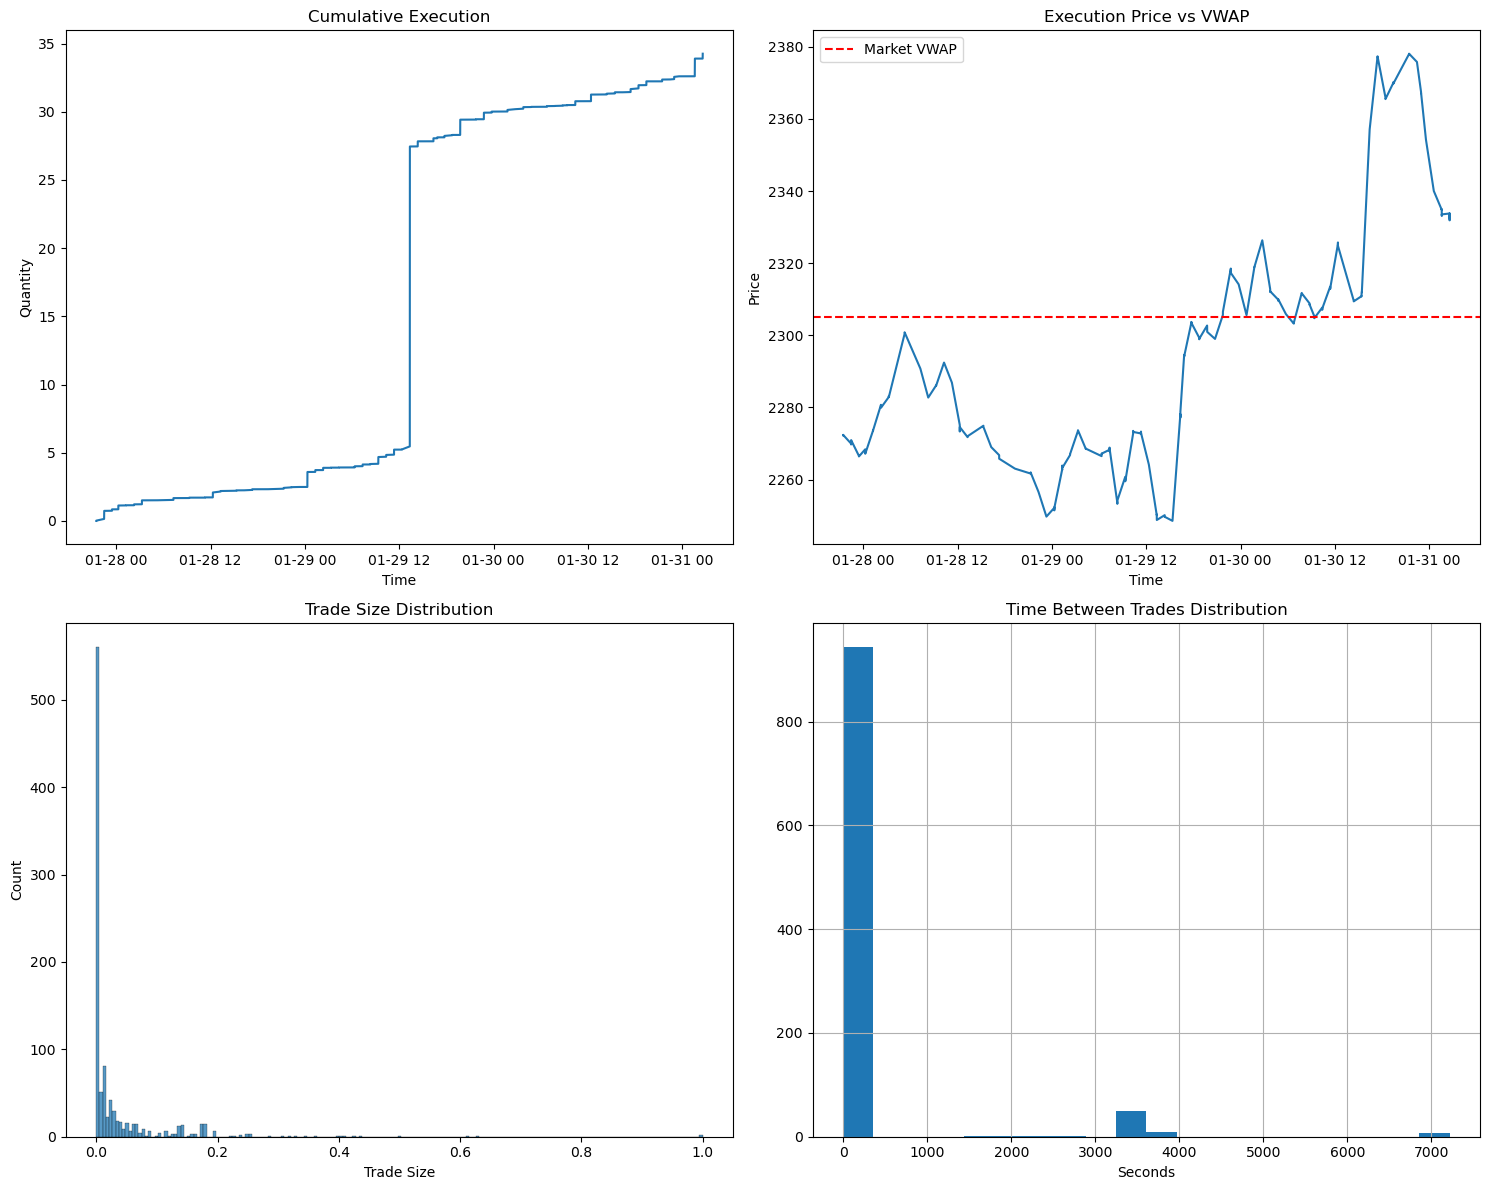

In [11]:
# Run the analysis
analysis_results, df_exec = analyze_vwap_execution(
    res, 
    df_trades_eth_usdt, 
    start_time = 0
)

# Print key metrics
print("\nTime Metrics:")
for k, v in analysis_results['time_metrics'].items():
    print(f"{k}: {v:.2f}")

print("\nPrice Metrics:")
for k, v in analysis_results['price_metrics'].items():
    print(f"{k}: {v:.2f}")

print("\nExecution Metrics:")
for k, v in analysis_results['execution_metrics'].items():
    print(f"{k}: {v:.2f}")

# Create visualization
fig = plot_execution_analysis(df_exec, analysis_results)
plt.show()

## ETH <> BTC

In [15]:
res = simulate_vwap_participation(df_trades_eth_btc, 
                                  df_orders_eth_btc, 
                                  target_quantity = 1, 
                                  start_time = 0, 
                                  participation_rate = 0.03, 
                                  pause_seconds = 1,
                                  is_crypto_pair = True
                                 )


Time Metrics:
total_time_seconds: 1706668485.00
notional_per_second: 0.00
avg_time_between_trades: 2160339.85

Price Metrics:
arrival_price: 0.05
market_vwap: 0.05
achieved_vwap: 0.05
price_improvement_bps: -37.75
vwap_improvement_bps: -73.25

Execution Metrics:
completion_rate: 0.00
trading_costs_bps: 10.00
avg_trade_size: 0.02
median_trade_size: 0.01
multi_level_impact_pct: 0.51


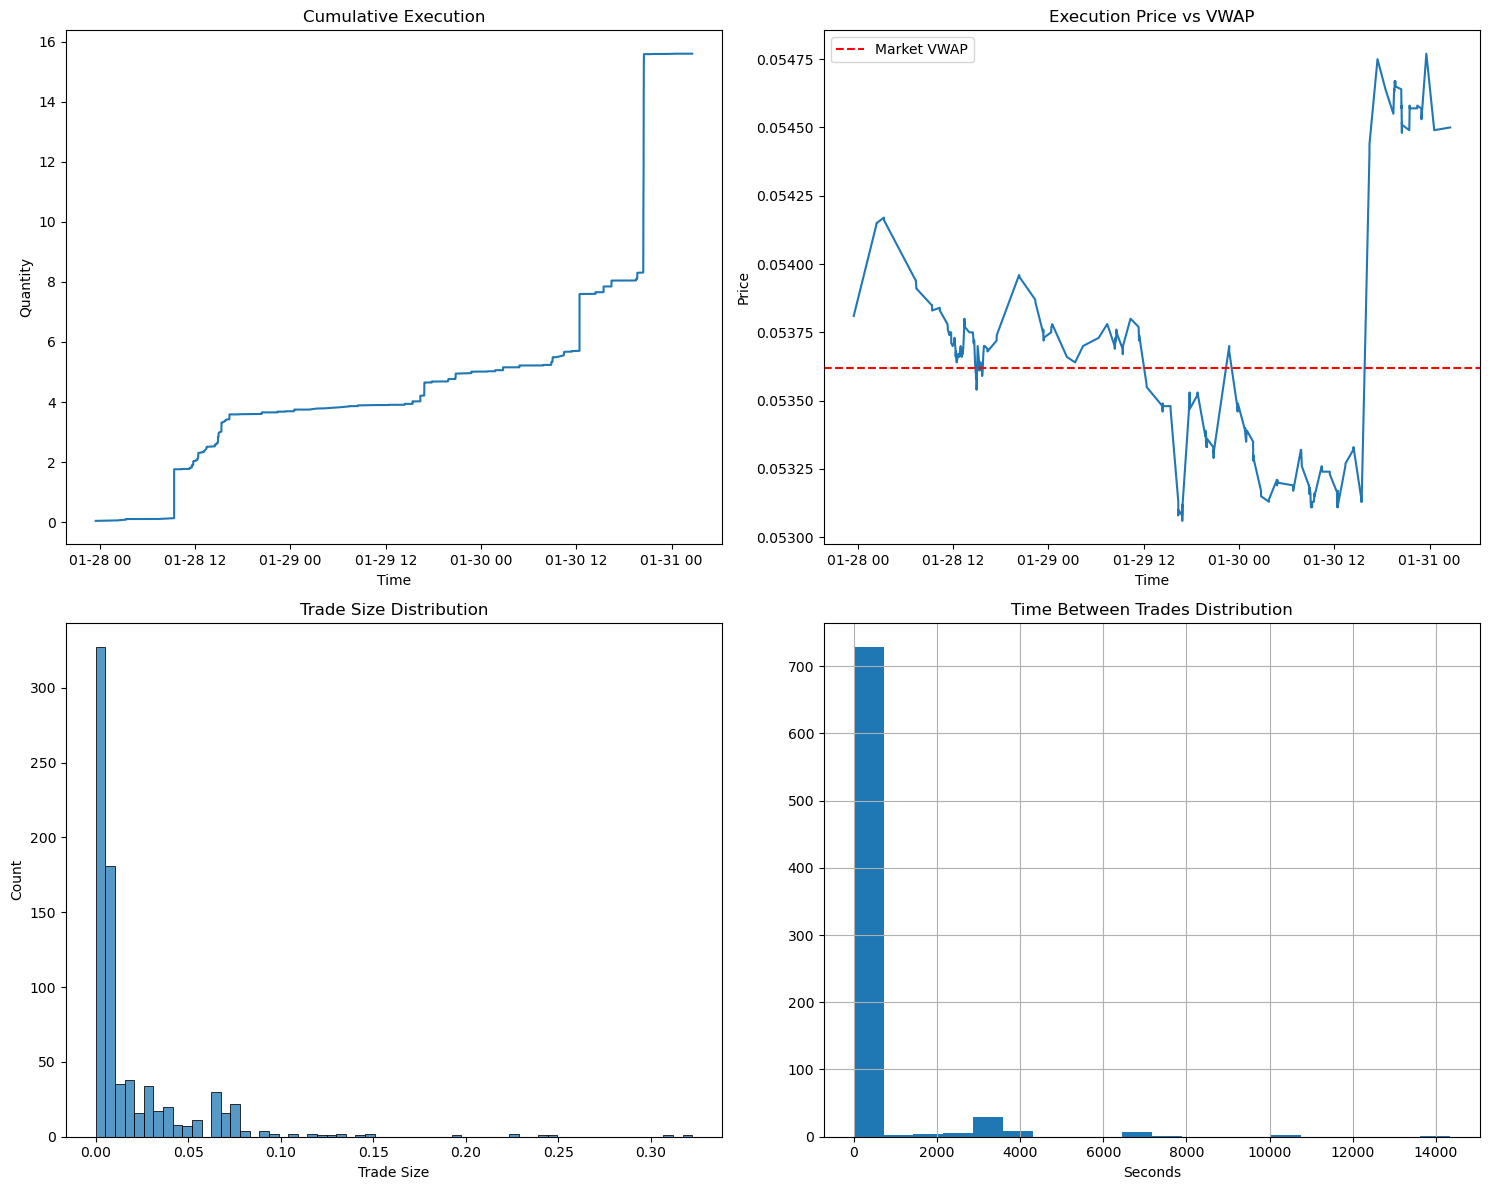

In [16]:
# Run the analysis
analysis_results, df_exec = analyze_vwap_execution(
    res, 
    df_trades_eth_btc, 
    start_time = 0
)

# Print key metrics
print("\nTime Metrics:")
for k, v in analysis_results['time_metrics'].items():
    print(f"{k}: {v:.2f}")

print("\nPrice Metrics:")
for k, v in analysis_results['price_metrics'].items():
    print(f"{k}: {v:.2f}")

print("\nExecution Metrics:")
for k, v in analysis_results['execution_metrics'].items():
    print(f"{k}: {v:.2f}")

# Create visualization
fig = plot_execution_analysis(df_exec, analysis_results)
plt.show()